# Treinamento de modelo de Machine Learning para análise de série temporal e previsão de consumo energético em edificações

Este notebook demonstra como foi feito o treinamento de um modelo para utilização neste [Dashboard](https://building-energy-dashboard.onrender.com)  sobre consumo energético em edificações. Para este processo utilizaremos algumas bibliotecas básicas de ciência de dados, com destaque para a biblioteca Darts, especializada em Machine Learning para séries temporais. Iniciamos com as devidas instalações e importações.

In [23]:
# Necessary for Google Colab
!pip install darts --quiet
!pip install matplotlib==3.1.3 --quiet
!pip install bz2file --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nfoursid 1.0.1 requires matplotlib>=3.3, but you have matplotlib 3.1.3 which is incompatible.
darts 0.22.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.


In [24]:
import pandas as pd
import numpy as np
import pickle
import bz2file as bz2
import requests
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')


from datetime import date
from typing import Tuple

TODAY = str(date.today())

from darts import TimeSeries
from darts.models import LightGBMModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics.metrics import mape, mase, smape, r2_score, rmse

from sklearn.preprocessing import MinMaxScaler




## Dados principais - Edificações

Os dados utilizados nesse processo são coletados de uma API fornecida pela prefeitura de Helsinki, na Finlândia. Para mais detalhes sobre esse processo, visite a explicação completa sobre o [Dashboard]().
Inicialmente vamos coletar a lista de edificações que se enquadram no tipo de uso "escritório". E para cada edifício, coletamos seu `propertyCode` que vamos usar posteriormente para coletar seus dados de consumo energético. Nesse processo, descartamos alguns códigos que estão vazios ou fora do padrão.

# Nova seção

# Nova seção

In [3]:
endpoint_offices = "https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/Search"
params_offices = {
        'SearchString': 'office',
        'SearchFromRecord': 'BuildingType',
        }
response_offices = requests.get(endpoint_offices, params=params_offices)

# Cleaning the nested keys
offices_list = response_offices.json()
to_exclude = ['reportingGroups', 'buildings']
new_list = []
for item in offices_list:
    new_item = {key: item[key] for key in item.keys() if key not in to_exclude}
    new_list.append(new_item)
df = pd.DataFrame.from_records(new_list)


In [4]:
propertyCodes = list(df['propertyCode'])

for item in propertyCodes:
  if (len(item) < 17) or (len(item) > 17):
    propertyCodes.remove(item)

len(propertyCodes)

163

Agora com os `propertyCode` coletados, vamos fazer uma busca pelos dados de cada edificação. No código abaixo montamos um Dataframe com os dados de todas as edificações. Para evitar erros e dados incompletos, primeiro testamos se a resposta da API é positiva (200), se os dados estão vazios ou se contém dados duplicados. Esses critérios foram utilizados pela observação desses problemas ao longo do processo. Dos 163 `propertyCodes` selecionados, apenas 70 foram bem sucedidos.

In [5]:
endpoint_energy = "https://helsinki-openapi.nuuka.cloud/api/v1/EnergyData/Daily/ListByProperty"

params_energy = {
        'Record': 'propertyCode',
        'SearchString': propertyCodes[0],
        'ReportingGroup': 'Electricity',
        'StartTime': '2020-01-01',
        'EndTime': TODAY,
        }
response_energy = requests.get(endpoint_energy, params=params_energy)
print(response_energy.status_code)

df_all = pd.DataFrame.from_dict(response_energy.json())
df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
#df_all = df_all.set_index(['timestamp'])
column_name = f'Building_{0}'
df_all = df_all.rename(columns={'value': column_name})
df_all = df_all.drop(['reportingGroup', 'locationName', 'unit'], axis=1)

for i in range(len(propertyCodes)):
  endpoint_energy = "https://helsinki-openapi.nuuka.cloud/api/v1/EnergyData/Daily/ListByProperty"

  params_energy = {
          'Record': 'propertyCode',
          'SearchString': propertyCodes[i],
          'ReportingGroup': 'Electricity',
          'StartTime': '2020-01-01',
          'EndTime': TODAY,
          }
  response_energy = requests.get(endpoint_energy, params=params_energy)
  #print(response_energy.status_code)

  if response_energy.status_code != 200:
    pass
  else:
    if not response_energy.json():
      pass
    else:
      temp_df = pd.DataFrame.from_dict(response_energy.json())
      temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'])
      #temp_df = temp_df.set_index(['timestamp'])
      column_name = f'Building_{i}'
      temp_df = temp_df.rename(columns={'value': column_name})
      temp_df = temp_df.drop(['reportingGroup', 'locationName', 'unit'], axis=1)
      if (temp_df['timestamp'].duplicated().sum() > 0):
        pass
      else:
        df_all = df_all.merge(temp_df, how='outer', on=['timestamp'])
        #print(f'--{i}', df_all.iloc[0, -1])



200


Em um segundo momento, foi possível perceber que alguns edifícios tinham pouca quantidade de dados ou que não estavam mais sendo atualizados. Para isso foi aplicado uma segunda camada de filtro, para deixar apenas os edifícios que possuem dados relevantes.
Em seguida foi feita a remoção de alguns valores que estavam muito discrepantes e substutuídos usando o método `foward fill` do Pandas. Também foram eliminados os zeros absolutos (substituídos por 0.1) para evitar problemas nas métrics de predição.

In [6]:
df_all_buildings = df_all.copy()
df_all_buildings = df_all_buildings.set_index(['timestamp'])
df_all_buildings.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1012 entries, 2020-01-01 to 2022-10-08
Data columns (total 70 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Building_0_x  839 non-null    float64
 1   Building_0_y  839 non-null    float64
 2   Building_1    1012 non-null   float64
 3   Building_2    1012 non-null   float64
 4   Building_3    1003 non-null   float64
 5   Building_5    1010 non-null   float64
 6   Building_7    1012 non-null   float64
 7   Building_8    1012 non-null   float64
 8   Building_10   1011 non-null   float64
 9   Building_12   1012 non-null   float64
 10  Building_14   1011 non-null   float64
 11  Building_15   1012 non-null   float64
 12  Building_16   1012 non-null   float64
 13  Building_17   1011 non-null   float64
 14  Building_21   1011 non-null   float64
 15  Building_25   38 non-null     float64
 16  Building_32   38 non-null     float64
 17  Building_33   1012 non-null   float64
 18  Building_3

In [7]:
for col in df_all_buildings.columns:
  if (df_all_buildings[col].isna().sum() > 500) or (df_all_buildings[col].tail(15).isna().sum() > 5):
    df_all_buildings = df_all_buildings.drop(columns=[col])

df_all_buildings.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1012 entries, 2020-01-01 to 2022-10-08
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Building_1    1012 non-null   float64
 1   Building_2    1012 non-null   float64
 2   Building_3    1003 non-null   float64
 3   Building_5    1010 non-null   float64
 4   Building_7    1012 non-null   float64
 5   Building_8    1012 non-null   float64
 6   Building_10   1011 non-null   float64
 7   Building_12   1012 non-null   float64
 8   Building_14   1011 non-null   float64
 9   Building_15   1012 non-null   float64
 10  Building_16   1012 non-null   float64
 11  Building_17   1011 non-null   float64
 12  Building_21   1011 non-null   float64
 13  Building_33   1012 non-null   float64
 14  Building_35   1010 non-null   float64
 15  Building_37   1010 non-null   float64
 16  Building_39   847 non-null    float64
 17  Building_45   878 non-null    float64
 18  Building_5

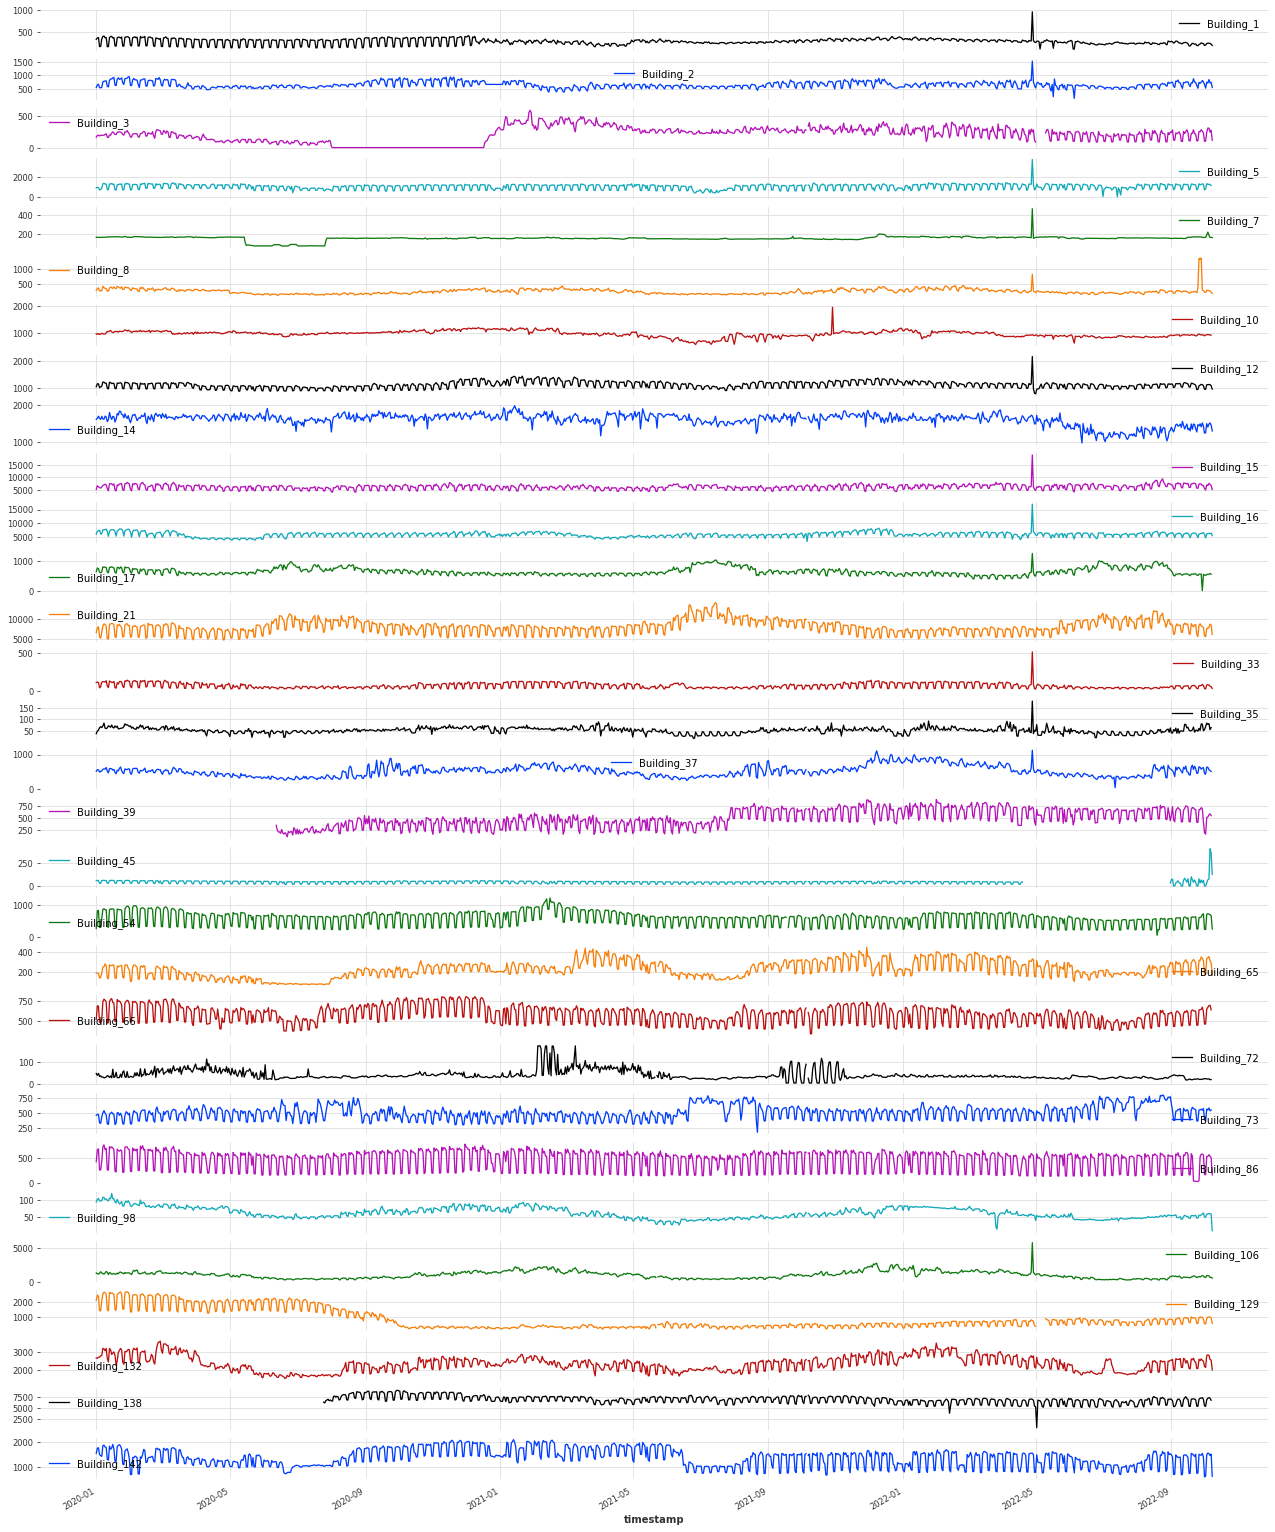

In [8]:
df_all_buildings.plot(figsize=(22, 30), subplots=True);

In [9]:
for col in df_all_buildings.columns:
  condition = col + " > 15000"
  if (df_all_buildings.query(condition).shape[0] > 0):
    df_all_buildings[col] = df_all_buildings[col].apply(lambda x : np.nan if x > 15000 else x)
    df_all_buildings[col].fillna(method='ffill')
  df_all_buildings[col] = df_all_buildings[col].apply(lambda x : 10 if x < 10 else x)


#df_all_buildings.plot(figsize=(22, 30), subplots=True);

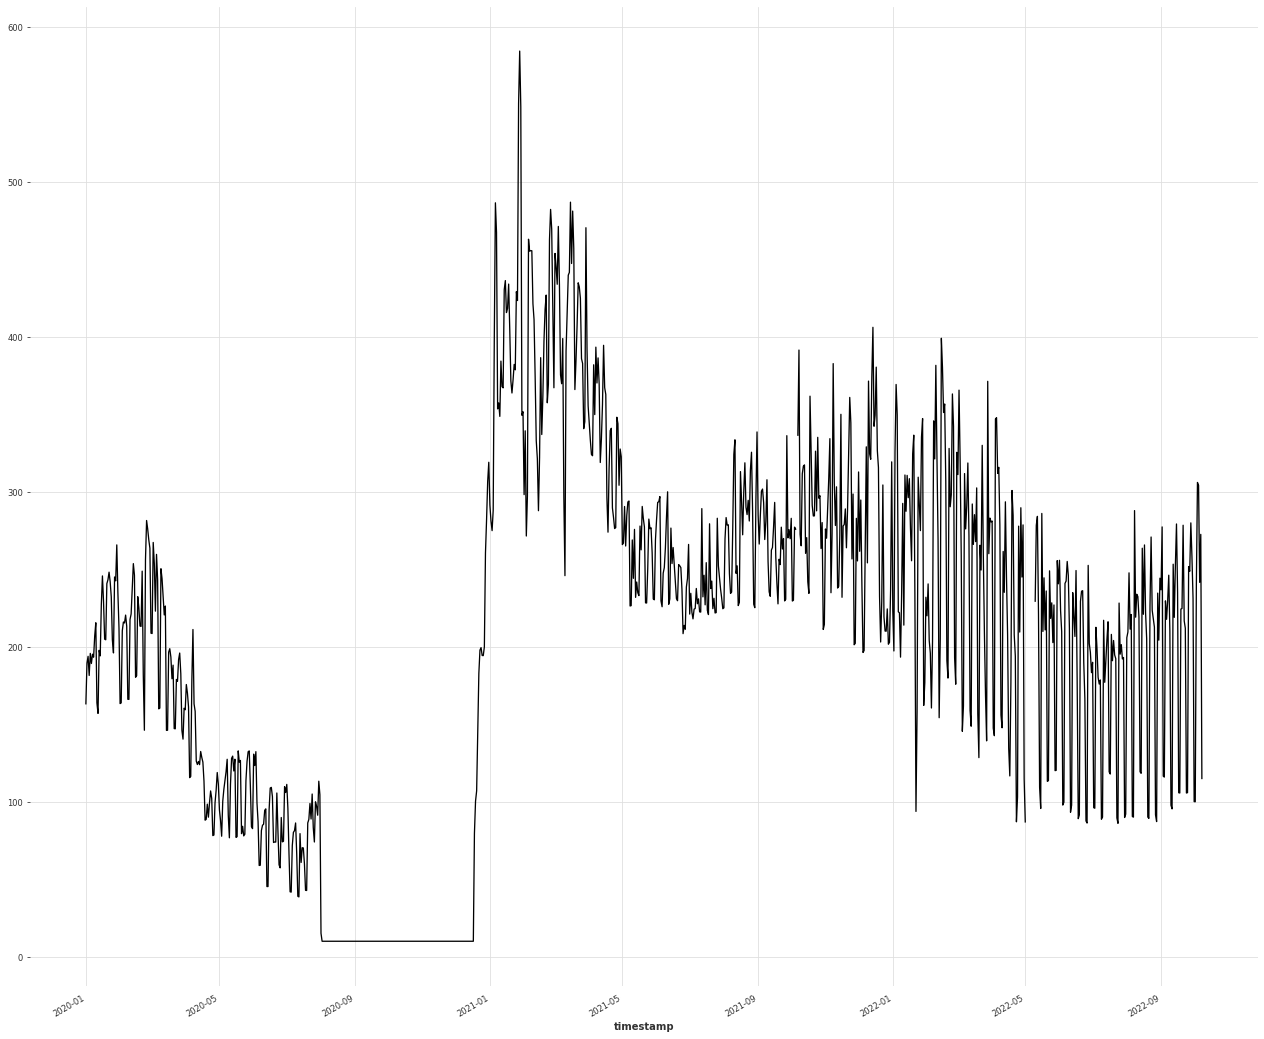

In [10]:
df_all_buildings['Building_3'].plot(figsize=(22, 20))

## Dados secundários - Climáticos

Como dados auxiliares no processo de treinamento e previsão do consumo energético dos prédios, serão utilizados dados climáticos, que sabidamente possuem forte influência no consumo energético das edificações. Esses dados influenciam na utlização intensidade da utilização de sistemas de aquecimento e resfriamento do prédio, impactando seu consumo energético.
Além disso foram criadas outras duas colunas de dados, uma relativa ao mês do anos e outra à finais de semana. Em geral, na visualização dos gráficos, podemos observar vales constantes na forma das linhas, que indicam uma redução de consumo nos finais de semana, o que é previsível, dado à menor utilização dos edifícios. Os meses do anos também são importantes pois estão ligados às estações do anos e as mudanças climáticas de cada período.
Vale ressaltar que combinamos dados históricos com dados de previsão do tempo, que serão utilizados tanto no treinamento como na previsão do modelo.

In [11]:
params = {
    "latitude":"60.19",
    "longitude":"24.94",
    "start_date":"2020-01-01",
    "end_date":TODAY,
    "hourly": ["temperature_2m", "relativehumidity_2m"],
    "timezone": "auto",
    }
endpoint = "https://archive-api.open-meteo.com/v1/era5"
response = requests.get(endpoint, params=params)
response.json()['hourly'].keys()

response_dict = response.json()['hourly']
df_hist_weather = pd.DataFrame.from_dict(response_dict)
df_hist_weather['time'] = pd.to_datetime(df_hist_weather['time'])
df_hist_weather.rename(columns={'time': 'timestamp'}, inplace=True)
df_hist_weather.set_index(['timestamp'], inplace=True)
df_hist_weather = df_hist_weather.resample('D').mean()


In [12]:
df_hist_weather.head()

,temperature_2m,relativehumidity_2m
timestamp,,
2020-01-01,1.079167,86.750000
2020-01-02,3.416667,87.666667
2020-01-03,4.975000,87.166667
2020-01-04,1.733333,74.166667
2020-01-05,-1.650000,68.833333


In [13]:
df_hist_weather = df_hist_weather[df_hist_weather['temperature_2m'].notna()]
df_hist_weather.tail(10)

,temperature_2m,relativehumidity_2m
timestamp,,
2022-09-26,9.054167,83.541667
2022-09-27,9.820833,81.875000
2022-09-28,8.900000,84.375000
2022-09-29,7.558333,93.041667
2022-09-30,7.745833,91.166667
2022-10-01,8.504167,87.250000
2022-10-02,8.404167,90.208333
2022-10-03,7.087500,86.875000
2022-10-04,7.325000,83.875000


In [14]:
params = {
    "latitude":"60.19",
    "longitude":"24.94",
    "hourly": ["temperature_2m", "relativehumidity_2m"],
    "past_days": 15,
    "timezone": "auto",
    }
endpoint = "https://api.open-meteo.com/v1/forecast"
response = requests.get(endpoint, params=params)
response.json()['hourly'].keys()


response_dict = response.json()['hourly']
df_fore_weather = pd.DataFrame.from_dict(response_dict)
df_fore_weather['time'] = pd.to_datetime(df_fore_weather['time'])
df_fore_weather.rename(columns={'time': 'timestamp'}, inplace=True)
df_fore_weather.set_index(['timestamp'], inplace=True)
df_fore_weather = df_fore_weather.resample('D').mean()



In [15]:
df_fore_weather

,temperature_2m,relativehumidity_2m
timestamp,,
2022-09-25,9.337500,75.208333
2022-09-26,10.225000,79.875000
2022-09-27,11.262500,79.083333
2022-09-28,9.837500,82.833333
2022-09-29,8.166667,89.000000
2022-09-30,8.795833,86.750000
2022-10-01,9.566667,85.916667
2022-10-02,10.200000,84.041667
2022-10-03,7.858333,83.916667


In [16]:
temp_hist = df_hist_weather['temperature_2m']
temp_fore = df_fore_weather['temperature_2m']
temp_all = temp_hist.combine_first(temp_fore)
temp_all.tail(25)


timestamp
2022-09-22     7.979167
2022-09-23     9.416667
2022-09-24     9.612500
2022-09-25     8.895833
2022-09-26     9.054167
2022-09-27     9.820833
2022-09-28     8.900000
2022-09-29     7.558333
2022-09-30     7.745833
2022-10-01     8.504167
2022-10-02     8.404167
2022-10-03     7.087500
2022-10-04     7.325000
2022-10-05     3.466667
2022-10-06    12.583333
2022-10-07    12.279167
2022-10-08    11.529167
2022-10-09     8.808333
2022-10-10    10.541667
2022-10-11     9.133333
2022-10-12     6.945833
2022-10-13     8.404167
2022-10-14    10.208333
2022-10-15     9.366667
2022-10-16     8.941667
Freq: D, Name: temperature_2m, dtype: float64

In [17]:
humidity_hist = df_hist_weather['relativehumidity_2m']
humidity_fore = df_fore_weather['relativehumidity_2m']
humidity_all = humidity_hist.combine_first(humidity_fore)
humidity_all.tail(25)

timestamp
2022-09-22    79.750000
2022-09-23    84.666667
2022-09-24    86.750000
2022-09-25    77.333333
2022-09-26    83.541667
2022-09-27    81.875000
2022-09-28    84.375000
2022-09-29    93.041667
2022-09-30    91.166667
2022-10-01    87.250000
2022-10-02    90.208333
2022-10-03    86.875000
2022-10-04    83.875000
2022-10-05    95.666667
2022-10-06    87.541667
2022-10-07    79.416667
2022-10-08    86.625000
2022-10-09    78.666667
2022-10-10    85.333333
2022-10-11    85.875000
2022-10-12    77.541667
2022-10-13    87.791667
2022-10-14    91.083333
2022-10-15    87.375000
2022-10-16    89.541667
Freq: D, Name: relativehumidity_2m, dtype: float64

In [18]:
df_all_weather = pd.concat([temp_all, humidity_all], axis=1)
df_all_weather

,temperature_2m,relativehumidity_2m
timestamp,,
2020-01-01,1.079167,86.750000
2020-01-02,3.416667,87.666667
2020-01-03,4.975000,87.166667
2020-01-04,1.733333,74.166667
2020-01-05,-1.650000,68.833333
...,...,...
2022-10-12,6.945833,77.541667
2022-10-13,8.404167,87.791667
2022-10-14,10.208333,91.083333


In [19]:
df_all_weather['weekend'] = (df_all_weather.index.dayofweek >= 5).astype(int)
df_all_weather['month'] = df_all_weather.index.month

df_all_weather


,temperature_2m,relativehumidity_2m,weekend,month
timestamp,,,,
2020-01-01,1.079167,86.750000,0,1
2020-01-02,3.416667,87.666667,0,1
2020-01-03,4.975000,87.166667,0,1
2020-01-04,1.733333,74.166667,1,1
2020-01-05,-1.650000,68.833333,1,1
...,...,...,...,...
2022-10-12,6.945833,77.541667,0,10
2022-10-13,8.404167,87.791667,0,10
2022-10-14,10.208333,91.083333,0,10


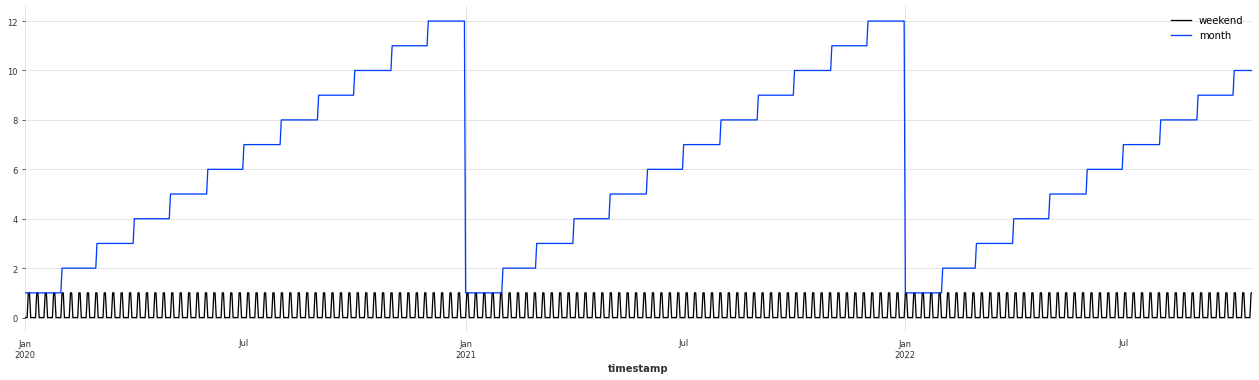

In [20]:
df_all_weather[['weekend', 'month']].plot(figsize=(22, 6));

## Trabalhando os dados com `TimeSeries` da biblioteca Darts

À seguir os dados são processados à partir da transformação em classes específicas da biblioteca Darts, que são as `TimeSeries`. São criados dois grupos:
  - Variáveis principais: à partir do Dataframe das Edificações, que são os dados que pretendemos fazer previsões
  - Covariáveis: são os dados que influenciam nas variávies principais, mas que não temos o objetivo de prever.
  Nesse caso, utlizaremos as covariáveis como covariáveis futuras (na definição do Darst: `future covariates`). Isso porque esses dados possuem registros na mesma linha do tempo dos nossos dados principais, mas ainda acrescenta dados futuros, pois coletamos dados da previsão do tempo.

Em seguida os dados são normalizados para o intervalo entre 0.0 e 1.0, que é mais adequado para o treinamento do modelo.

In [25]:
series_buildings = TimeSeries.from_dataframe(df_all_buildings)
series_covariates = TimeSeries.from_dataframe(df_all_weather)

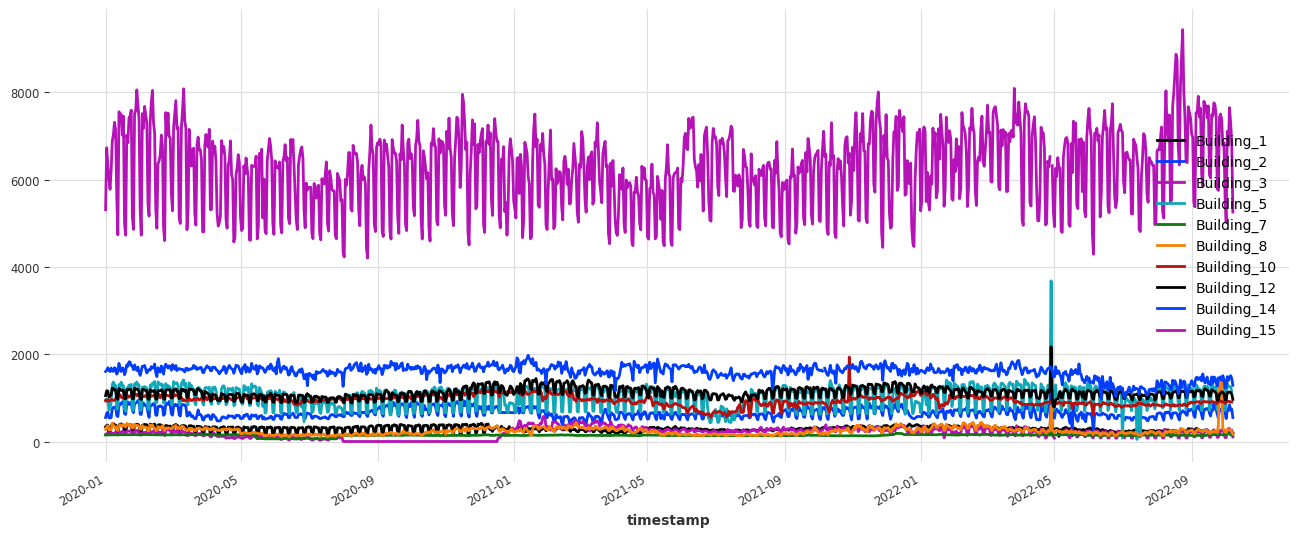

In [26]:
# O plot do Darts se limita a apenas 10 componentes
plt.figure(figsize=(16, 6), dpi=100)
series_buildings.plot();

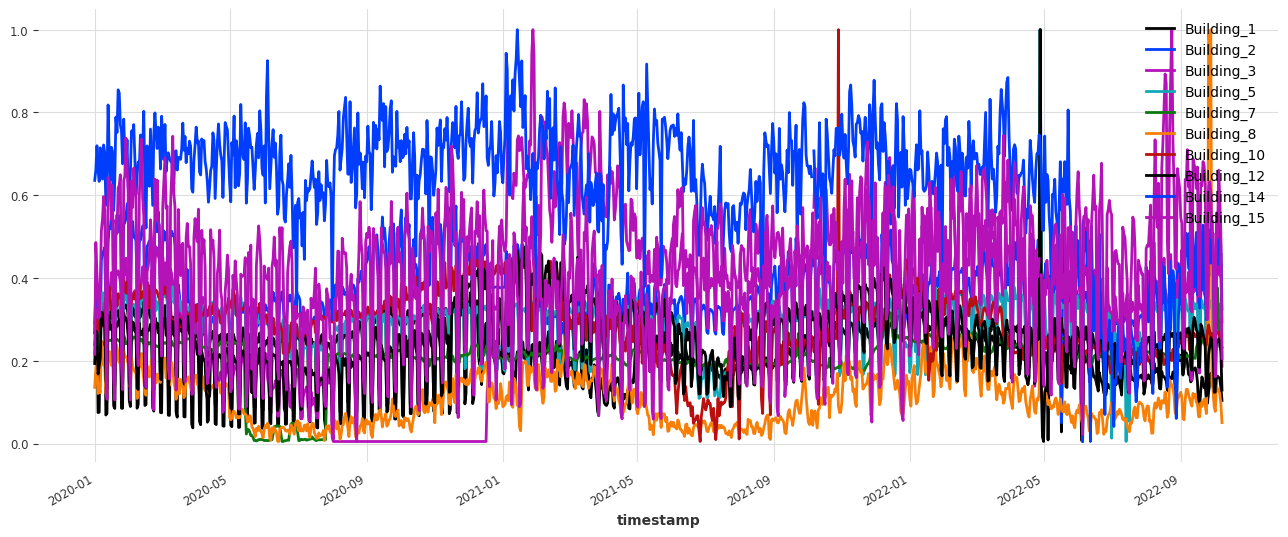

In [27]:
scaler_buildings = Scaler(scaler=MinMaxScaler(feature_range=(0.005, 1)))
series_buildings_scaled = scaler_buildings.fit_transform(series_buildings)

plt.figure(figsize=(16, 6), dpi=100)
series_buildings_scaled.plot()

In [28]:
series = series_buildings_scaled['Building_3'].pd_series()
series[series <= 0]

Series([], Freq: D, dtype: float64)

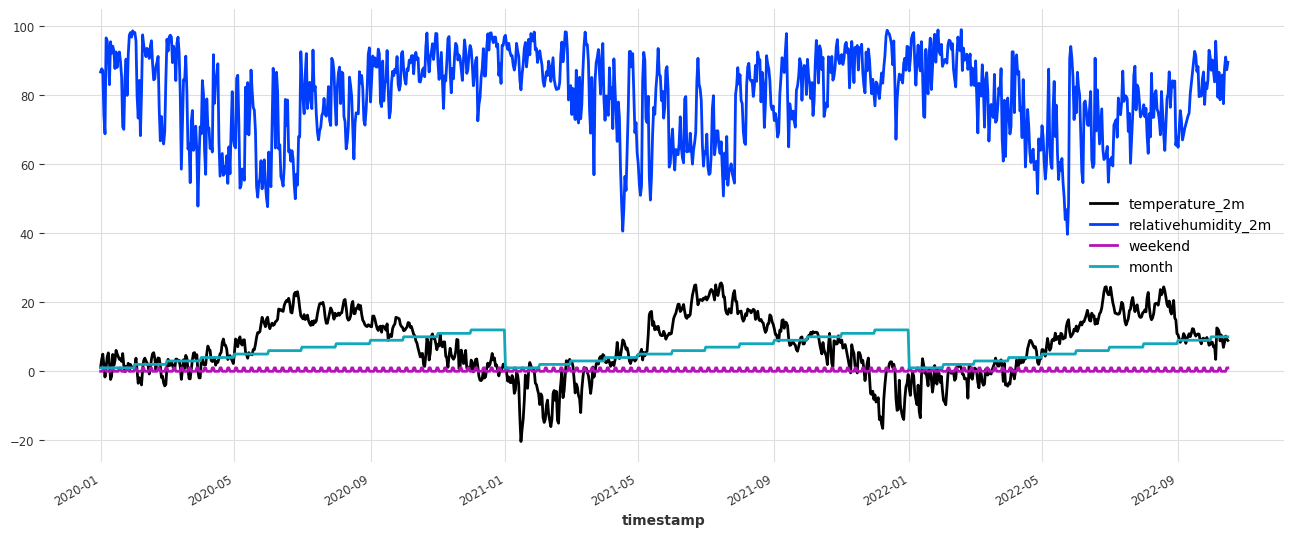

In [29]:
plt.figure(figsize=(16, 6), dpi=100)
series_covariates.plot()

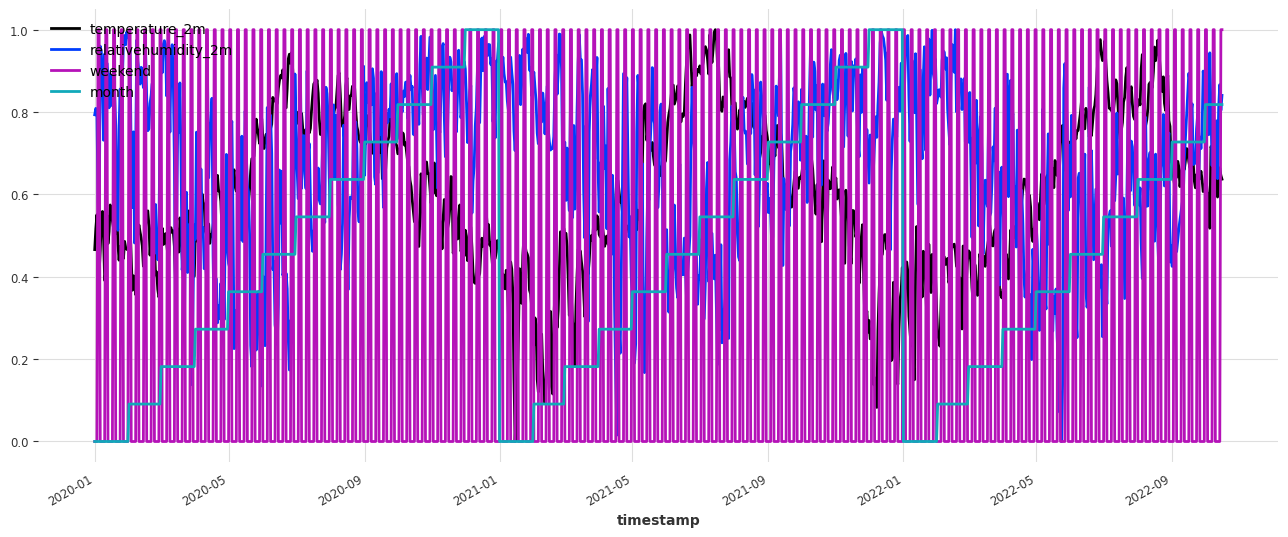

In [30]:
scaler_covariates = Scaler()
series_covariates_scaled = scaler_covariates.fit_transform(series_covariates)

plt.figure(figsize=(16, 6), dpi=100)
series_covariates_scaled.plot()

Como input para o modelo, passaremos uma lista de séries (cada uma representando uma edificação) e as covariáveis precisam ser passadas também em uma lista no mesmo formato da lista dos dados principais.
O modelo é criado com `lag=90` e `output_chunk_length=30`, ou seja, os dados são divididos em series de 90 entradas para 30 saídas, e vai sucessivamente avançando em ciclos até ler o conjunto completo.

In [34]:
model_test = LightGBMModel(
    lags=90,
    lags_future_covariates=(90, 1),
    output_chunk_length=30,
)

In [35]:
series_list_train=[]
for col in series_buildings_scaled.columns:
  series_list_train.append(series_buildings_scaled[col][:-30])

len(series_list_train)


30

In [36]:
series_list_test=[]
for col in series_buildings_scaled.columns:
  series_list_test.append(series_buildings_scaled[col][-30:])


len(series_list_test)


30

In [37]:
future = series_covariates_scaled

covariates_list = []
for i in range(len(series_list_train)):
  covariates_list.append(future)
len(covariates_list)

30

In [42]:
model_test.fit(
  series = series_list_train, 
  future_covariates=covariates_list, 
)

### Resultados

Após o treinamento do modelo, foi criado o gráfico abaixo com a comparação entre a previsão e os testes. É possível perceber que o modelo foi relativamente bem em grande parte dos casos, mas em alguns ficou mais distoante. É possível que isso se deva ao fato de que algumas dessas séries tem formatos mais aleatórios. Uma possibilidade a ser testada é treinar o modelo com uma série menor - de 1 ano, ao invés de mais de 2 anos.

Em seguida, foi utilizado a métrica de RMSE para cada um dos edifícios.

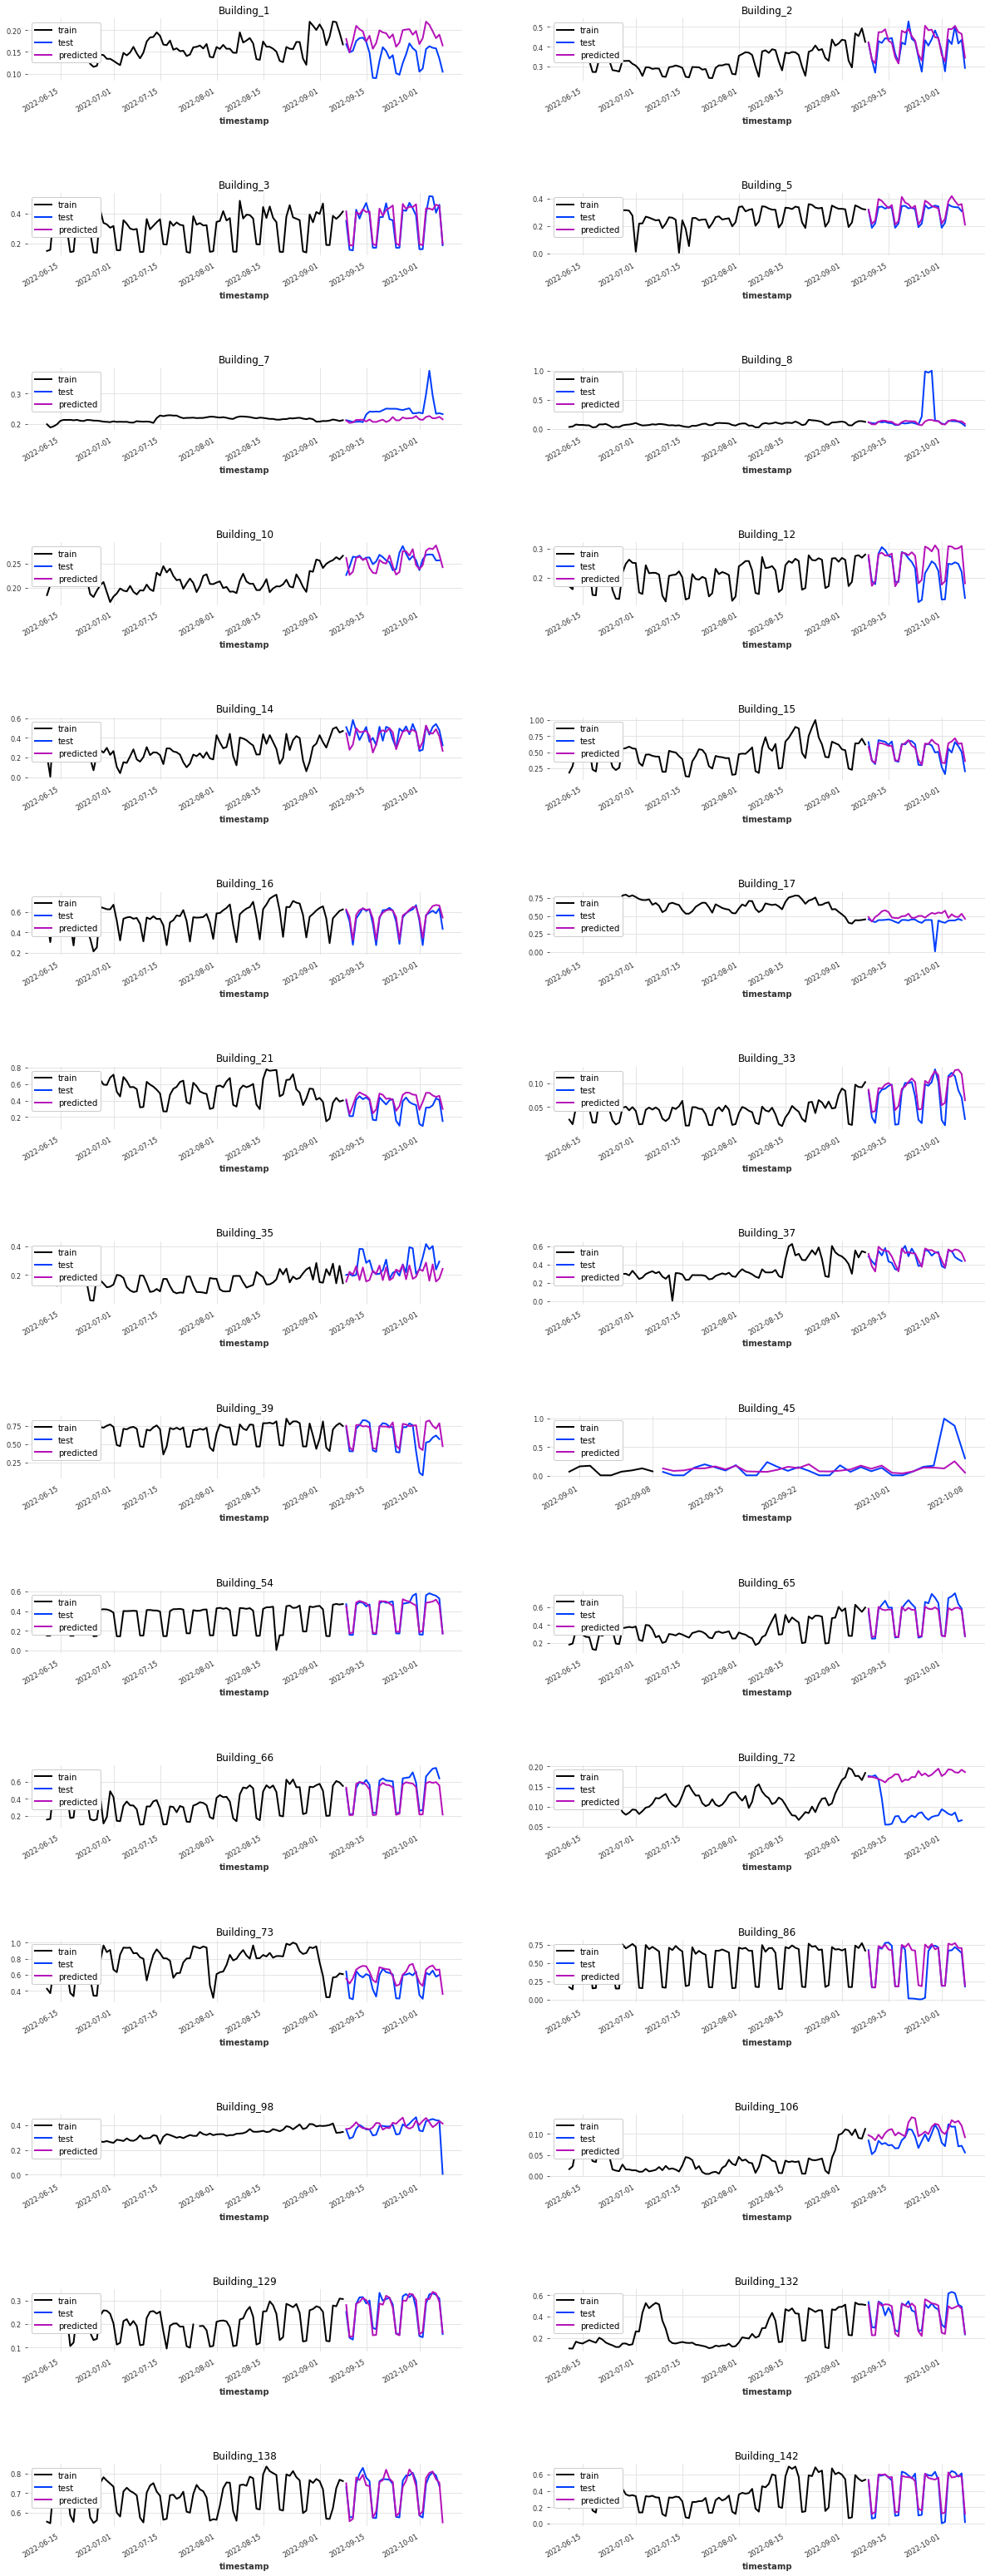

In [45]:
figure = plt.figure(1, figsize=(20, 56))

for i in range(len(series_list_train)):
  ax = plt.subplot(16, 2, i+1)
  series = series_list_train[i]
  test = series_list_test[i]
  pred = model_test.predict(30, series=series, future_covariates=future)
  series[-90:].plot(label = 'train');  
  test.plot(label = 'test');  
  pred.plot(label = 'predicted');
  plt.title(series.columns[0])
  ax.legend(loc='upper left', frameon= True, framealpha=1.0)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=1.8)

  

In [46]:
for i in range(len(series_list_train)):
  series = series_list_train[i]
  pred = model_test.predict(30, series=series, future_covariates=future)
  test_result = rmse(series_list_test[i], pred)
  print(f"The RMSE for Buildin {series_list_train[i].columns[0]} is: {test_result:.2f}")



The RMSE for Buildin Building_1 is: 0.05
The RMSE for Buildin Building_2 is: 0.04
The RMSE for Buildin Building_3 is: 0.05
The RMSE for Buildin Building_5 is: 0.03
The RMSE for Buildin Building_7 is: 0.04
The RMSE for Buildin Building_8 is: 0.27
The RMSE for Buildin Building_10 is: 0.02
The RMSE for Buildin Building_12 is: 0.05
The RMSE for Buildin Building_14 is: 0.08
The RMSE for Buildin Building_15 is: 0.08
The RMSE for Buildin Building_16 is: 0.04
The RMSE for Buildin Building_17 is: 0.13
The RMSE for Buildin Building_21 is: 0.12
The RMSE for Buildin Building_33 is: 0.02
The RMSE for Buildin Building_35 is: 0.10
The RMSE for Buildin Building_37 is: 0.05
The RMSE for Buildin Building_39 is: 0.15
The RMSE for Buildin Building_45 is: 0.21
The RMSE for Buildin Building_54 is: 0.04
The RMSE for Buildin Building_65 is: 0.07
The RMSE for Buildin Building_66 is: 0.07
The RMSE for Buildin Building_72 is: 0.10
The RMSE for Buildin Building_73 is: 0.11
The RMSE for Buildin Building_86 is: 0.2

---

## Treinando o modelo com os dados completos

O modelo agora será treinado com os dados completos, sem a divisão entre treino e teste. Vale lembrar que, mesmo utilizando os dados completos, as covariantes futuras contém registros de previsão do tempo que estão à frente da linha do tempo de consumo energético, o que será ajudará no desempenho das previsões.

Após o treinamento do modelo, é feito o testo com um edifício aleatório para testar a previsão.

In [31]:
series_all_train=[]
for col in series_buildings_scaled.columns:
  series_all_train.append(series_buildings_scaled[col])

len(series_all_train)

30

In [32]:
model = LightGBMModel(
    lags=90,
    lags_future_covariates=(90, 1),
    output_chunk_length=30,
)

In [38]:
model.fit(
  series = series_all_train, 
  future_covariates=covariates_list, 
)

In [118]:
endpoint_energy = "https://helsinki-openapi.nuuka.cloud/api/v1/EnergyData/Daily/ListByProperty"

params_energy = {
        'Record': 'propertyCode',
        'SearchString': propertyCodes[5],
        'ReportingGroup': 'Electricity',
        'StartTime': '2020-01-01',
        'EndTime': TODAY,
        }
response_energy = requests.get(endpoint_energy, params=params_energy)
print(response_energy.status_code)

new_building = pd.DataFrame.from_dict(response_energy.json())
new_building['timestamp'] = pd.to_datetime(new_building['timestamp'])
new_building = new_building.set_index(['timestamp'])
column_name = f'Building {0}'
new_building = new_building.rename(columns={'value': column_name})
new_building = new_building.drop(['reportingGroup', 'locationName', 'unit'], axis=1)


new_building



200


,Building 0
timestamp,
2020-01-01,558.36
2020-01-02,653.64
2020-01-03,681.24
2020-01-04,553.26
2020-01-05,547.68
...,...
2022-10-04,722.82
2022-10-05,848.04
2022-10-06,726.78


LGBModel(lags={'target': [-90, -89, -88, -87, -86, -85, -84, -83, -82, -81, -80, -79, -78, -77, -76, -75, -74, -73, -72, -71, -70, -69, -68, -67, -66, -65, -64, -63, -62, -61, -60, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1], 'future': [-90, -89, -88, -87, -86, -85, -84, -83, -82, -81, -80, -79, -78, -77, -76, -75, -74, -73, -72, -71, -70, -69, -68, -67, -66, -65, -64, -63, -62, -61, -60, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0]})


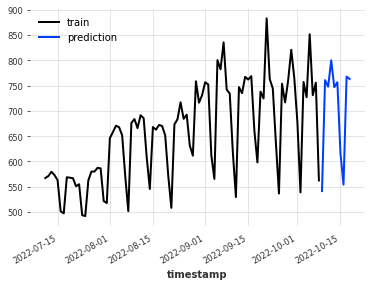

In [119]:
series = TimeSeries.from_dataframe(new_building, fill_missing_dates=True)
series_scaled = scaler_buildings.fit_transform(series)
pred = model.predict(10, series=series_scaled, future_covariates=future)
#series_scaled[-90:].plot()
#pred.plot()

scaler_inverse = Scaler()
series_inverted = scaler_inverse.fit(series)
series_inverted = scaler_inverse.inverse_transform(series_scaled)
series_inverted[-90:].plot(label='train')
pred_inverted = scaler_inverse.inverse_transform(pred)
pred_inverted.plot(label='prediction')
print(model)


In [41]:
with bz2.BZ2File('ts_model' + '.pbz2', 'w') as f:
  pickle.dump(model, f)

#model.save('ts_model.pkl')

In [112]:
future.to_pickle('future_covariates.pkl')